<a href="https://colab.research.google.com/github/rezamohamadlo/Sunspot-Predictor/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8


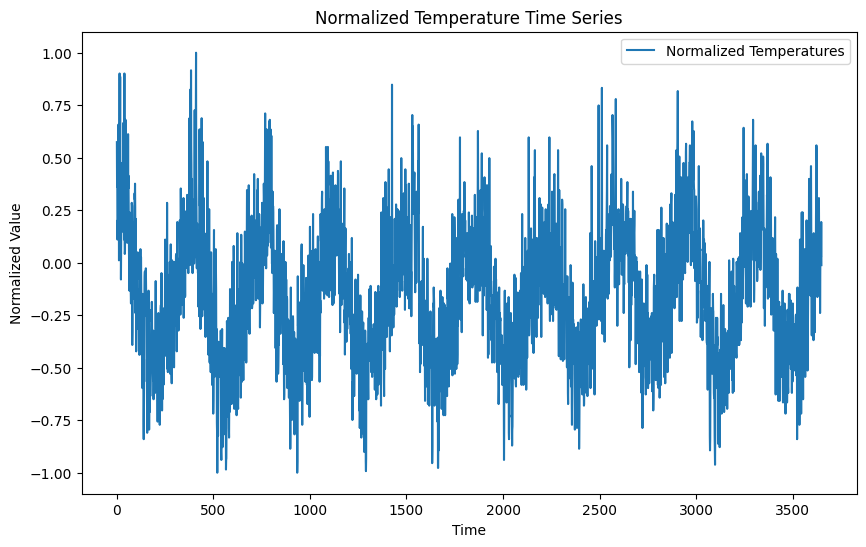

Data preprocessing completed and datasets saved.


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
data = pd.read_csv(url, parse_dates=['Date'], index_col='Date')

# Display the first few rows of the dataset
print(data.head())

# Extract the temperature values
temperatures = data['Temp'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
temperatures_normalized = scaler.fit_transform(temperatures.reshape(-1, 1))

# Convert to NumPy array
temperatures_normalized = np.array(temperatures_normalized).flatten()

# Define window size and split time
window_size = 60
split_time = int(len(temperatures_normalized) * 0.8)  # 80% for training

# Prepare the dataset using a sliding window approach
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# Create training and validation datasets
batch_size = 100
shuffle_buffer_size = 1000

train_set = windowed_dataset(
    temperatures_normalized[:split_time],
    window_size=window_size,
    batch_size=batch_size,
    shuffle_buffer=shuffle_buffer_size
)

valid_set = windowed_dataset(
    temperatures_normalized[split_time:],
    window_size=window_size,
    batch_size=batch_size,
    shuffle_buffer=shuffle_buffer_size
)

# Convert datasets to numpy arrays for saving
def dataset_to_numpy(ds):
    arrays = []
    for batch in ds:
        arrays.append(batch[0].numpy())  # Extract the features
        arrays.append(batch[1].numpy())  # Extract the labels
    return np.concatenate(arrays, axis=0)

# Save preprocessed data as NumPy arrays
np.save('temperatures_normalized.npy', temperatures_normalized)
np.save('train_set.npy', dataset_to_numpy(train_set))
np.save('valid_set.npy', dataset_to_numpy(valid_set))

# Visualize the normalized data
plt.figure(figsize=(10, 6))
plt.plot(range(len(temperatures_normalized)), temperatures_normalized, label='Normalized Temperatures')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.title('Normalized Temperature Time Series')
plt.legend()
plt.show()

print('Data preprocessing completed and datasets saved.')
